### The Project

The Project
The goals / steps of this project are the following:


• Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

• Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

• Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

• Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

• Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

• Estimate a bounding box for vehicles detected.

In [70]:
# Header files and imports

import os
import glob
import math

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

### Gather and combine all data for vehcile and non - vehicles

In [71]:
base = './dataset/vehicles/'
folders = os.listdir(base)

cars = []
for folder in folders:
    cars.extend(glob.glob(base+folder+'/*'))

base = './dataset/non-vehicles/'
folders = os.listdir(base)

notcars = []
for folder in folders:
    notcars.extend(glob.glob(base+folder+'/*'))
    
print("Number of Vehicle Images found: {}".format(len(cars)))
print("Number of Non-Vehicle Images found: {}".format(len(notcars)))

Number of Vehicle Images found: 8792
Number of Non-Vehicle Images found: 8968


In [109]:
'''Function to display multiple images and plot them'''

def display_img(images, titles):
    if(images[0].shape[1]!=images[0].shape[0]):
        rows = math.ceil(len(images)/2)
        cols = 2
        fig = plt.figure(figsize=(17, 4 *  math.ceil(len(images)/2) ))
    else:
        rows = math.ceil(len(images)/4)
        cols = 4
        fig = plt.figure(figsize=(17, 4 *  math.ceil(len(images)/4) ))

        

    for i, img in enumerate(images):
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        plt.title(titles[i])
        if len(img.shape) < 3:
            plt.imshow(img, cmap = "hot")
        else:
            plt.imshow(img)

    plt.tight_layout()

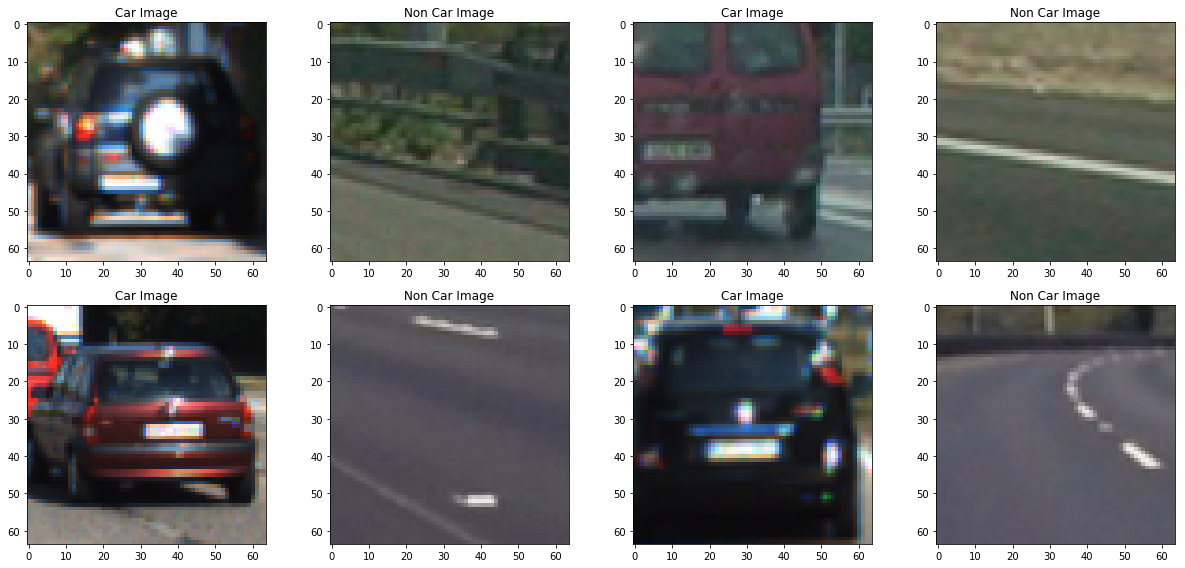

In [92]:
# Display 6 random images

test_images = []
test_titles = []

for i in range(4):
    # Choose random car/notcar indicies
    car_ind = np.random.randint(0,len(cars))
    notcar_ind = np.random.randint(0,len(notcars))

    # Read images
    car_image = mpimg.imread(cars[car_ind])
    notcar_image = mpimg.imread(notcars[notcar_ind])
    
    test_images.extend([car_image, notcar_image])
    test_titles.extend(["Car Image", "Non Car Image"])
    
display_img(test_images, test_titles)

#Reset
test_images = []
test_titles = []

### Function Definitions

In [93]:
'''Function to return HOG features and visualization'''

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [94]:
'''Function to compute binned color features'''  

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [95]:
'''Function to compute color histogram features'''  

def color_hist(img, nbins=32): #, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins) #, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins) #, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins) #, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [96]:
'''Function to extract features from a list of images'''

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    """Define a function to extract features from a list of images
    Have this function call bin_spatial() and color_hist()
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        file_features = single_img_features(image, color_space=color_space, spatial_size=spatial_size,
                                            hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                            cell_per_block=cell_per_block,
                                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                                            hist_feat=hist_feat, hog_feat=hog_feat)
        features.append(file_features)
        
    # Return list of feature vectors
    return features

In [97]:
'''Function that takes an image, start and stop positions in both x and y, window size 
(x and y dimensions), and overlap fraction (for both x and y)'''

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    x_start_stop = list(x_start_stop)
    y_start_stop = list(y_start_stop)
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    # Return the list of windows
    return window_list

In [98]:
'''Function to draw bounding boxes'''

def draw_boxes(img, bboxes, color=(255, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [99]:
'''Function to extract features of a single image only once'''

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    hog_image = []
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))     
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=True)

            #else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False)
                
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

In [100]:
'''Function you will pass an image and the list of windows to be searched'''

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

/home/laavanye/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


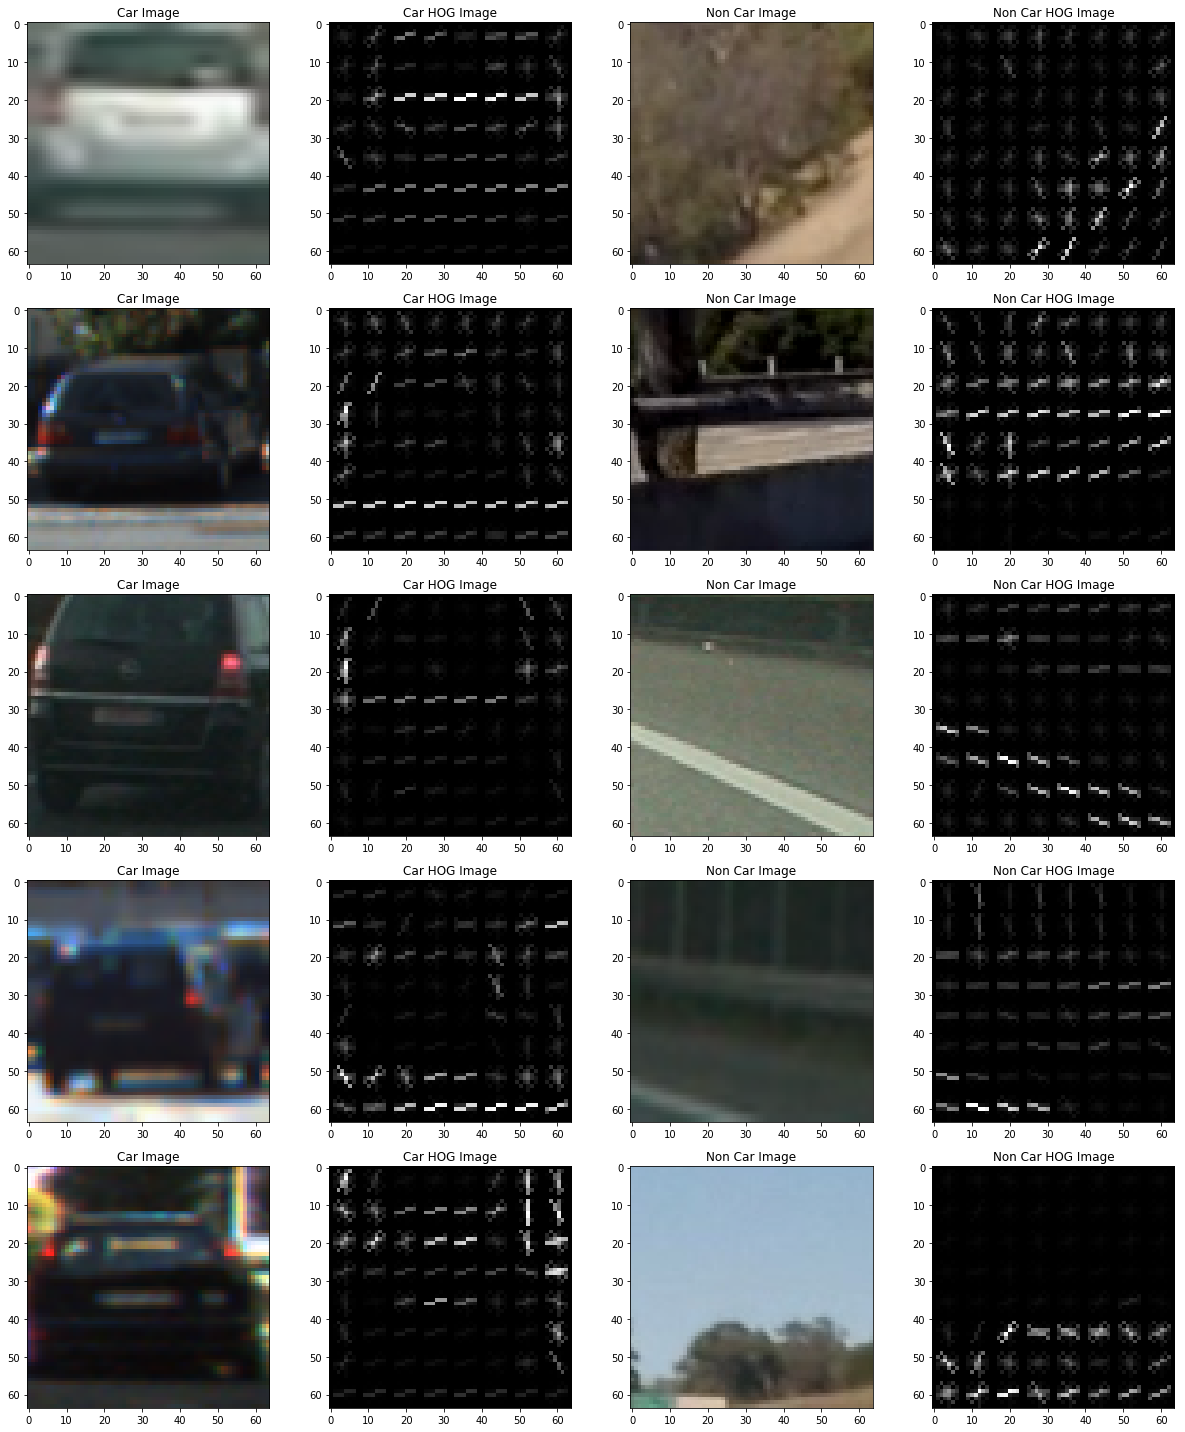

In [101]:
# ----------------------------------  TEST ---------------------------------------------
# Visualize HOG Images

for i in range(5):
    # Choose random car/notcar indicies
    car_ind = np.random.randint(0,len(cars))
    notcar_ind = np.random.randint(0,len(notcars))

    # Read images
    car_image = mpimg.imread(cars[car_ind])
    notcar_image = mpimg.imread(notcars[notcar_ind])

    # Define feature parameters
    color_space = "YCrCb" # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 0 # Can be 0,1,2, "ALL"
    spatial_size = (16,16)
    hist_bins = 16
    spatial_feat = True
    hist_feat = True
    hog_feat = True

    car_features, car_hog_image = single_img_features(car_image, color_space=color_space, 
                            spatial_size=spatial_size,
                            hist_bins=hist_bins, orient=orient,
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

    notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size,
                            hist_bins=hist_bins, orient=orient,
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
    
    test_images.extend([car_image, car_hog_image, notcar_image, notcar_hog_image])
    test_titles.extend(["Car Image", "Car HOG Image", "Non Car Image", "Non Car HOG Image"])

display_img(test_images,test_titles)
    

#Reset
test_images = []
test_titles = []

### Define parameters for features

In [102]:
color_space = "YCrCb" # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 # HOG orientations
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True
y_start_stop = [None, None]

t=time.time()

test_cars = cars
test_notcars = notcars

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC(C=0.01)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


/home/laavanye/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
16.85 Seconds to train SVC...
Test Accuracy of SVC =  0.9949


###  Test images results

/home/laavanye/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


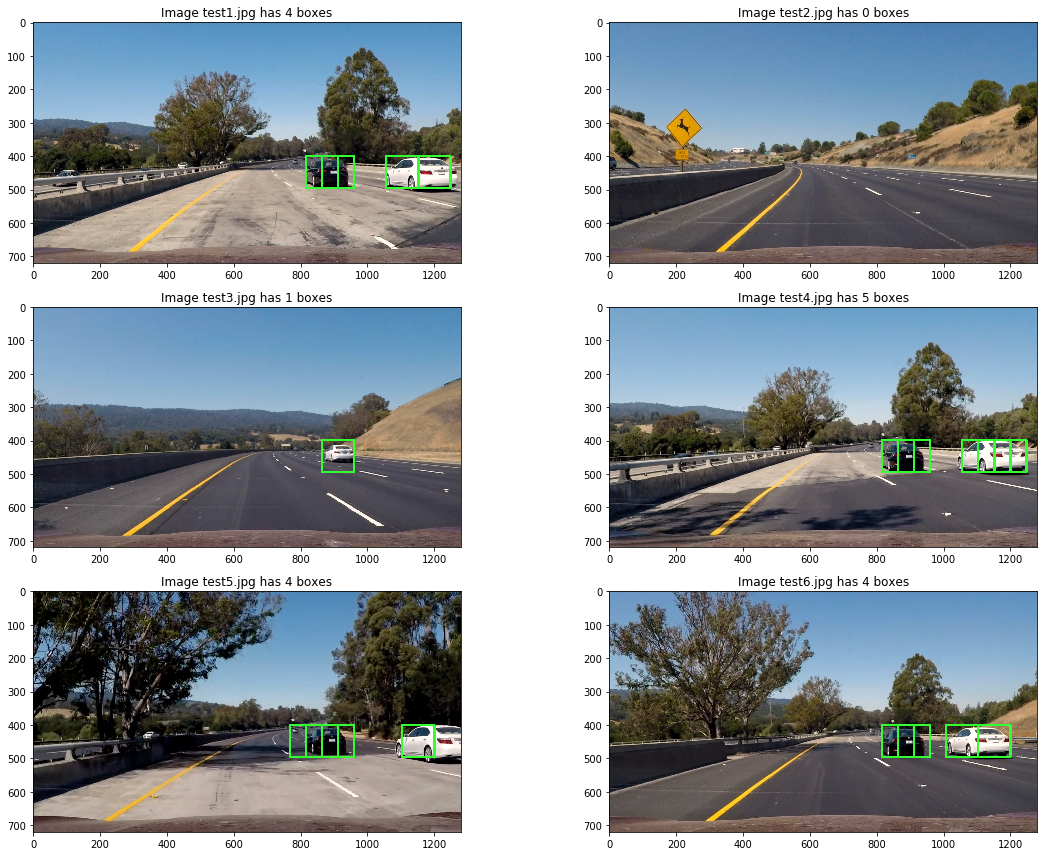

In [111]:
test_image_path = "./test_images/*"
test_folder_images = sorted(glob.glob(test_image_path))
y_start_stop = [400,720] # restrict search region

for i,img in enumerate(test_folder_images):
    image = mpimg.imread(img)
    draw_image = np.copy(image)

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    str = "Image {} has {} boxes".format(os.path.basename(img),len(hot_windows))
    window_img = draw_boxes(draw_image, hot_windows, color=(50, 255, 50), thick=6)                    

    test_images.append(window_img)
    test_titles.append(str)

display_img(test_images,test_titles)
    

#Reset
test_images = []
test_titles = []

### Hog Sub-sampling Window Search

/home/laavanye/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.4148423671722412 seconds to run, total windows = 441
0.449368953704834 seconds to run, total windows = 441
0.3914463520050049 seconds to run, total windows = 441
0.38822245597839355 seconds to run, total windows = 441
0.4429035186767578 seconds to run, total windows = 441
0.39067745208740234 seconds to run, total windows = 441


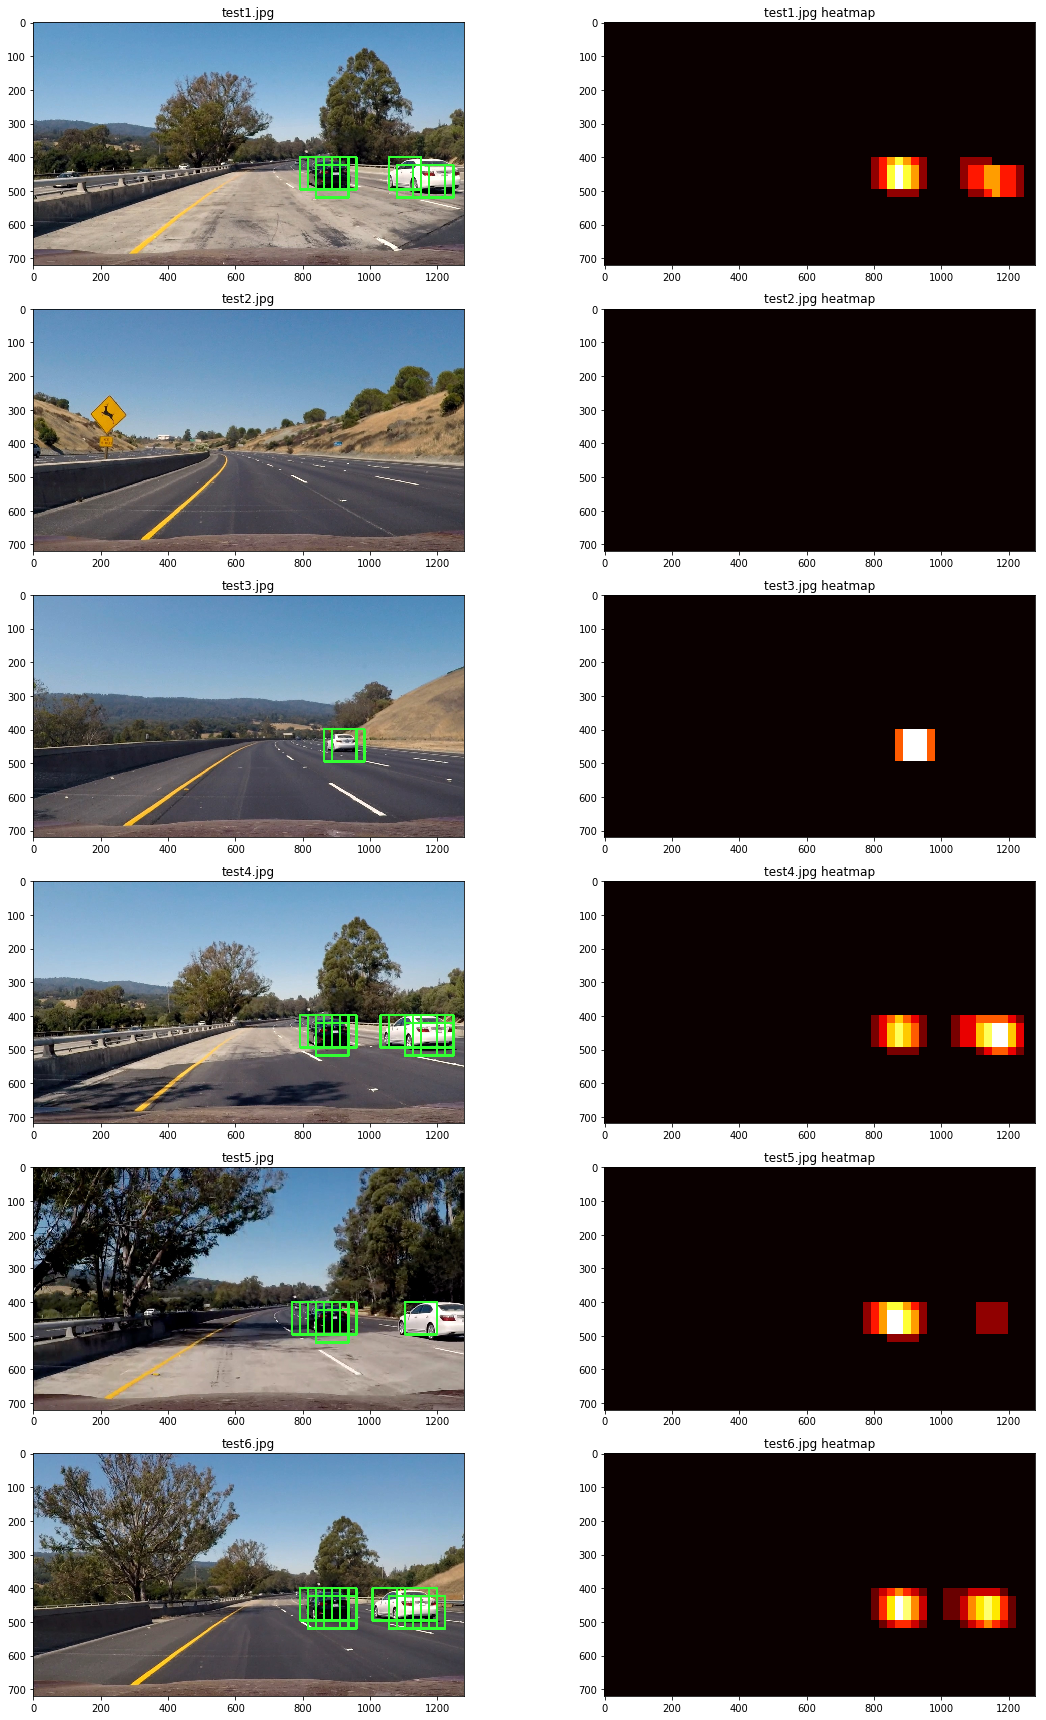

In [113]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

ystart = 400
ystop = 720
scale = 1.5

for i,img_src in enumerate(test_folder_images):
    img_boxes = []
    t=time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    # make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch =  cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale),(np.int(imshape[0]/scale))))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # define blocks and steps
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # compute individual channel HOG features
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()

            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            subimg = cv2.resize(ctrans_tosearch[ytop: ytop+window, xleft:xleft+window], (64,64))
            
            #color and spatial binning 
            spatial_features = bin_spatial(subimg, size=(spatial_size))
            hist_features = color_hist(subimg, nbins = hist_bins)

            # scale features and make a prediction
            features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1)
            test_features = X_scaler.transform(features)

            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)

                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart),
                                  (xbox_left+win_draw, ytop_draw + win_draw+ystart), (50, 255, 50), 6)
                img_boxes.append(((xbox_left, ytop_draw+ystart),
                                  (xbox_left+win_draw, ytop_draw + win_draw+ ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left: xbox_left+win_draw] += 1

    print("{} seconds to run, total windows = {}".format(time.time()-t, count))

    test_images.append(draw_img)

    test_titles.append(os.path.basename(img_src))
    test_titles.append(os.path.basename(img_src)+" heatmap")

    test_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)

display_img(test_images, test_titles)
    

#Reset
test_images = []
test_titles = []
    